In [1]:
# Load in our libraries
# ml_practice
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)

from sklearn.svm import SVC
from sklearn.model_selection import KFold

Feature Exploration, Engineering and Cleaning

이제 우리는 대부분의 커널이 구조화된 방식과 같이 진행해 나갈 것이며, 그것은 먼저 손에 잡히는 데이터를 살펴보고, 가능한 feature enginering 기회를 식별하고, 어떤 범주형 특징을 수치적으로 인코딩하는 것이다

In [2]:

# Load in the train and test datasets
train = pd.read_csv('../../input/train.csv')
test = pd.read_csv('../../input/test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

# embarked -> 어디에서 배를 탔나
# SibSp -> 배우자나 형제 자매 명 수의 총합
# Parch -> 부모 자식 명 수  

# PClass -> Categorical. 사회경제적 지위. (1에 가까울 수록 높음)
# class	1 = 1st, 2 = 2nd, 3 = 3rd

# Ticket -> 티켓 번호. 
# Fare ->  티켓 가격. 

# Embarked -> C = Cherbourg, Q = Queenstown, S = Southampton

# Cabin ->  해당 사람의 숙소? 가 어디있는지에 대한 값

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


여기에서 기능 엔지니어링 아이디어에 대한 Sina의 매우 포괄적이고 잘 고안된 노트북으로 크레딧을 연장해야하므로 
그의 작업을 확인하십시오.

타이타닉 Best Working Classfier : Sina 제작
https://www.kaggle.com/sinakhorami/titanic-best-working-classifier

In [3]:
full_data = [train, test]


train['Name_length'] = train['Name'].apply(len) # 이름의 길이를 저장.. 
test['Name_length'] = test['Name'].apply(len)   # 이름의 길이를 저장..


In [4]:
# Some features of my own that I have added in
# Gives the length of the name


# x가 float이면 0이고 아니면 1 
#선실번호. 
#근데 cabin피쳐는 ..? string인데 왜 float로 한 거지..? 
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x:0 if type(x) ==float else 1)

In [6]:
# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
#print(full_data)
print(type(full_data))

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    

<class 'list'>


In [7]:
# 배우자, 형제자매 + 부모자식 명수 

    
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] ==1, 'IsAlone'] = 1
    
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] ==1, 'IsAlone'] = 1
    
# Embarked 컬럼의 NULL 제거 

for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    

# Fare 컬럼의 모든 NULL값 제거 후 평균값으로 채우고, Categorical Fare 항목 만들기 

for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    #평균값..
    
# Create a New feature CategoricalAge
# Categorical Age.. 새로운 feature 추가 
for dataset in full_data:
    age_avg = dataset['Age'].mean() #평균 
    age_std = dataset['Age'].std()  # ???
    age_null_count = dataset['Age'].isnull().sum() #sum??
    age_null_random_list = np.random.randint(age_avg - age_std, 
                                             age_avg + age_std, 
                                             size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

train['CategoricalAge'] = pd.cut(train['Age'], 5)
# 동일 길이로 범주화

# 승객 이름에서 title을 뽑아놓기 위해 

def get_title(name):
    
    title_search = re.search('([A-Za-z]+)\.', str(name))
    # 이름이 string이 아닌 경우로 인식되는 경우가 있는 듯. string으로 바꿈.
    # title이 존재하면 -> 추출해서 리턴 시킴
    
    if title_search:
        return title_search.group(1) #->????
    return ""
    
# passeger들의 이름을 포함한 title 이라는 새로운 feature생성. 
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# 자주 등장하지 않는 모든 feature들을 "Rare"라는 그룹으로 바꾼다.

for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 
                                                 'Countess', 'Capt', 'Col', 'Don', 'Dr',
                                                 'Major', 'Rev', 'Sir', 'Johnkheer', 'Dona'
                                                ], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    #규칙이 있어서 이렇게 한건가.. 
 


for dataset in full_data:

    dataset['Sex'] = dataset['Sex'].map( {'female':0, 'male':1}).astype(float)
    '''
    The lack of NaN rep in integer columns is a pandas "gotcha".
    The usual workaround is to simply use floats.
    '''
    # 타이틀을 매핑 
    
    title_mapping = {"Mr":1, "Miss":2, "Mrs":3, "Master":4, "Rare":5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
                                                
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S':0, 'C':1, 'Q':2} ).astype(float) 
    
    # Mapping Fare
    print( "최소값:",dataset['Fare'].min() , "최대값:",dataset["Fare"].max() )
    
        #이 숫자는 뭘 기준으로..?
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[ (dataset['Fare']>7.91) & (dataset['Fare']<=14.454), 'Fare'] = 1
    dataset.loc[ (dataset['Fare']>14.454) & (dataset['Fare']<=31), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    
    dataset['Fare'] = dataset['Fare'].astype(float) #-> 왜 한거임..?
    # pandas 버전 바뀌면서 dataset['Fare'].astype(int)가 안 됨
    
    dataset.loc[ dataset['Age'] <=16.0, 'Age'] = 0
    dataset.loc[ (dataset['Age'] > 16.0) & (dataset['Age']<=32.0), 'Age'] = 1
    dataset.loc[ (dataset['Age']>32) & (dataset['Age']<=48), 'Age'] = 2
    dataset.loc[ (dataset['Age']>48) & (dataset['Age']<=64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4;

최소값: 0.0 최대값: 512.3292
최소값: 0.0 최대값: 512.3292


In [8]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

이제 feature를 정리하고 관련 정보를 추출하고 범주형 열을 삭제했습니다. 

이제 우리의 기능은 모두 숫자, 즉 기계 학습 모델에 적합한 형식이 되어야 합니다. 
하지만 진행하기 전에 변환된 데이터 세트의 간단한 상관 관계 및 분포도를 생성합니다.


In [9]:

train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1.0,1,0,0.0,0.0,23,0,2,0,1.0
1,1,1,0.0,2,0,3.0,1.0,51,1,2,0,3.0
2,1,3,0.0,1,0,1.0,0.0,22,0,1,1,2.0


Pearson 상관 관계 HeatMap입니다.

한 feature이 다른 feature과 얼마나 관련이 있는지 알아보기 위해 feature의 상관 관계를 몇 가지 생성해 보겠습니다. 

이를 위해 다음과 같이 heat map를 매우 편리하게 그릴 수 있는 Seaborn 플로팅 패키지를 활용할 예정입니다.

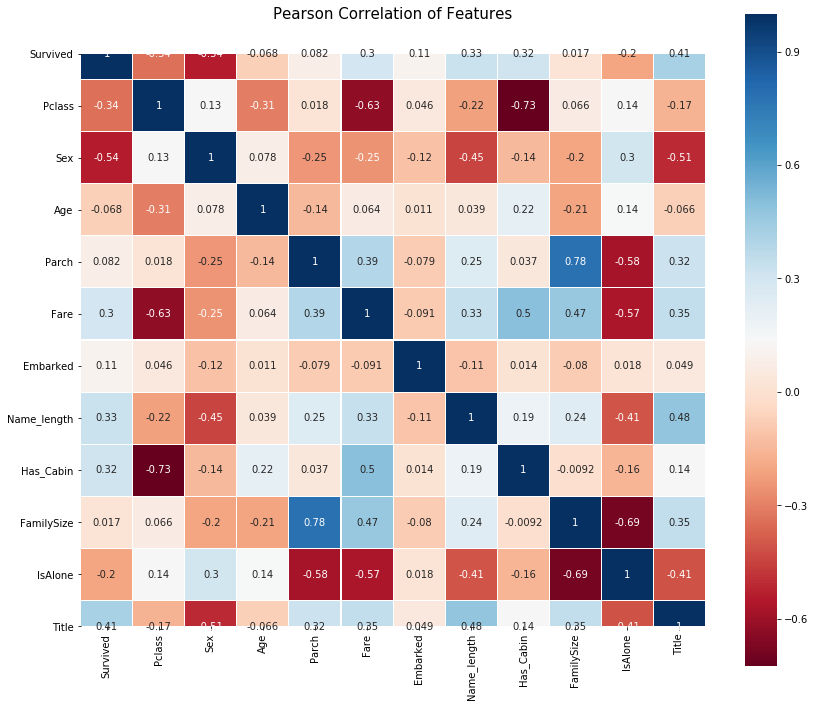

In [10]:

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)

sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, 
           cmap = colormap, linecolor='white', annot=True)


Takeaway from Plots

Pearson Correlation 그림에서 알 수 있는 한 가지는 서로 강하게 연관되어 있는 형상이 그리 많지 않다는 것입니다. 

이는 이러한 기능을 학습 모델에 제공하는 관점에서 볼 때 유용합니다. 즉, training set에 중복되거나 불필요한 데이터가 별로 없고 각 기능이 고유한 정보를 제공하게 되어 좋기 때문입니다. 

Family size와 Parch(부모와 자녀)의 두 가지가 가장 상관 관계가 있는 Feature입니다. 이 연습의 목적을 위해 두 가지 기능을 모두 그대로 두겠습니다.

Pair Plots입니다.

마지막으로 한 feature에서 다른 feature으로의 데이터 분포를 관찰할 수 있는 몇 가지 페어 플롯을 생성하겠습니다. 
다시 한번, 우리는 우리를 돕기 위해 Seaborn을 사용합니다.

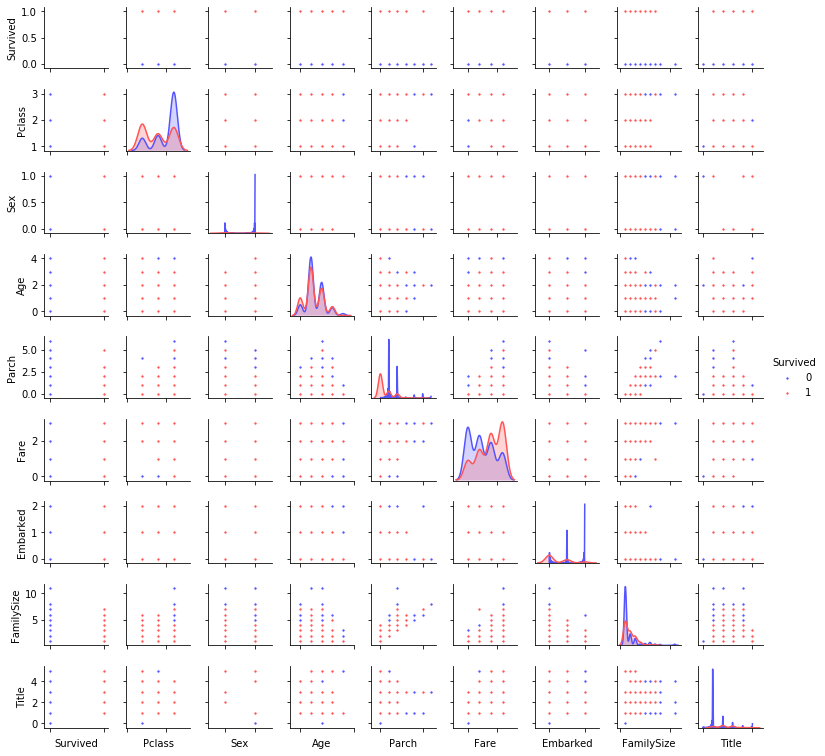

In [11]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked', 
                       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic', size=1.2,
                        diag_kind='kde', diag_kws = dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

#-> 이거 왜 한거지.?

###  Ensembling & Stacking models

마지막으로 feature 엔지니어링 및 formatting과 관련하여 간단하게 살펴본 후, 우리는 마침내이 노트북의 핵심과 요점에 도달합니다.

모델을 조립하고 쌓습니다.
마지막으로, feature engineering과 포맷에 관해 짧게 알아본 후, 우리는 마침내 이 노트의 핵심에 도달했습니다.

Stacking ensemble을 만듭니다!

### Helpers via Python Class

여기서는 Python의 수업을 사용하여 우리에게 더 편리하게 만들 수 있도록 도와줍니다. 프로그래밍을 시작한 초보자의 경우 일반적으로 OOP(Object-Oriented Programming)와 함께 클래스가 사용되는 것을 들을 수 있습니다. 간단히 말해, 클래스는 객체(구식 핍에 대한 변수)를 작성하기 위한 일부 코드/프로그램을 확장하고 해당 클래스에 특정한 기능과 방법을 구현하는 데 도움이 됩니다.

아래 코드 섹션에서는 기본적으로 모든 Sklearn 분류기에 공통적으로 사용되는 내장 방법(예: 열차, 예측 및 적합)을 확장할 수 있는 클래스 SklearnHelper를 작성합니다. 따라서 5개의 다른 분류기를 호출하려면 동일한 방법을 다섯 번 쓸 필요가 없으므로 중복성이 차단됩니다.

In [20]:
# 차후에 유용하게 쓰일 파라미터

ntrain = train.shape[0] #y축 갯수
ntest = test.shape[0]
SEED = 0 # 재사용을 위해
NFOLDS = 5 # out-of-fold 예측을 위해
######kf = KFold(ntrain, n_splits=NFOLDS, random_state=SEED)
#-> deprecated

#kf = KFold(ntrain, n_splits = NFOLDS, random_state=SEED) 
kf = KFold(n_splits=NFOLDS)
kf = kf.split(ntrain) #->???

In [21]:
# Sklearn 분류기 확장을 위한 클래스 
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        print(self.clf.fit(x,y).feature_importances_)
    

이 사실을 이미 알고 계신 분들을 위해, 그러나 이전에 파이썬에서 클래스나 오브젝트를 만들지 않은 분들을 위해, 위에 주어진 코드가 무엇을 하는지 설명하겠습니다. 기본 분류기를 만들 때 이미 Sklearn 라이브러리에 있는 모델만 사용하므로 해당 클래스를 확장합니다.

def init : 클래스에 대한 기본 생성자를 호출하기 위한 Python 표준입니다. 
즉, 객체(분류기)를 만들려면 clf(sklearn 분류기)와 SEED(Random Seed) 및 Params(분류기용 파라미터)의 파라미터를 지정해야 합니다.

나머지 코드는 단순히 클래스의 메서드이며, 단순히 SKlearn 분류기 내에 이미 존재하는 해당 메서드를 호출합니다.

기본적으로, 우리는 다양한 Sklearn 분류기를 확장하기 위해 Wrapper 클래스를 만들었습니다. 이렇게 하면 staker에 여러 learner를 구현할 때 동일한 코드를 반복해서 쓸 필요가 줄어듭니다.


#Out-of-Fold Predictions
이제 소개 섹션에서 위에서 설명한 것처럼 스태킹은 기본 분류기의 예측을 두 번째 수준 모델에 대한 훈련을 위한 입력으로 사용합니다. 그러나 전체 학습 데이터에서 base 모델들을 학습시키고 전체 테스트 세트에 대한 예측을 생성 한 다음 2 차 훈련을 위해 이를 출력 할 수는 없습니다. 이건  기본 모델 예측이 이미 테스트 세트를 "보았"으므로 이러한 예측을 제공 할 때 과적 합 될 위험이 있습니다.


In [22]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))  #training 데이터를 training 데이터 크기만큼 세로로 0으로 채우고 
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x, test) # clf에서 예측한 값을 
        
    oof_test[:] = oof_test_skf.mean(axis=0)  #test열을 skf의 평균치로..................?
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)


기본 1단계 모델을 생성합니다.

이제 5가지 학습 모델을 첫 번째 레벨 분류로 준비하겠습니다. 이러한 모델은 모두 Sklearn 라이브러리를 통해 편리하게 호출할 수 있으며 다음과 같이 나열됩니다.

1.랜덤 포리스트 분류기
2.Extra Trees 분류기입니다.
3.AdaBoost classifier입니다.
4.Gradient Boosting Classifier
5.Support Vector Machine


Parameters
매개변수를 간략하게 요약합니다.

n_jobs : 학습 프로세스에 사용되는 코어 수입니다. -1로 설정하면 모든 코어가 사용됩니다.

n_estimators : 학습 모델의 분류 트리의 개수(기본값당 10개로 설정됩니다)

max_deep : 트리의 최대 깊이 또는 노드를 확장할 크기입니다. 너무 높게 설정하면 tree가 너무 깊이 자라서 tree가 overfitting될 위험이 있습니다.

상세 내역 : 학습 프로세스 중에 텍스트를 출력할지 여부를 제어합니다. 값이 0이면 모든 텍스트가 억제되고 값이 3이면 반복할 때마다 트리 학습 프로세스가 출력됩니다.

공식 Sklearn 웹사이트를 통해 자세한 설명을 확인하시기 바랍니다. 여기에서 다른 유용한 매개 변수를 모두 사용하여 재생할 수 있습니다.

In [23]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs':-1,
    'n_estimators': 500,
    'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs':-1,
    'n_estimators':500,
    'max_depth':8,
    'min_samples_leaf':2,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators':500,
    'max_depth':5,
    'min_samples_leaf':2,
    'verbose':0
}
# Support Vector Classifier parameters 
svc_params = {
    'kernel': 'linear',
    'C': 0.025
}

또한, OOP 프레임워크 내의 개체 및 클래스에 대해 언급했으므로 앞에서 정의한 Helper Sklearn 클래스를 통해 5가지 학습 모델을 나타내는 5가지 개체를 만들겠습니다.


In [27]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

#### Creating NumPy arrays out of our train and test sets

첫 번째 계층의 base 모델을 준비한 후 다음과 같이 원래 데이터 프레임에서 NumPy 배열을 생성하여 분류기에 입력 할 수 있도록 학습 및 테스트 데이터를 준비 할 수 있습니다.

In [28]:
# test와 target dataframe을 우리의 모델에 넣기 위해 training용 numpy 배열 생성

y_train = train['Survived'].ravel() #1차원 배열로 리턴 

train = train.drop(['Survived'], axis=1)

x_train = train.values
x_test= test.values

KeyError: 'Survived'

In [29]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier


print("Training is complete")

TypeError: Singleton array array(891) cannot be considered a valid collection.

#### Feature importances generated from the different classifiers


이제 첫 번째 수준 분류기를 배웠으므로 Sklearn 모델의 매우 유용한 기능을 활용할 수 있으며 이는 매우 간단한 코드 라인으로 training 및 test 세트의 다양한 기능의 중요성을 출력합니다.

Sklearn 문서에 따르면 대부분의 분류기는 .featureimportances를 입력하여 feature importance를 반환하게 됩니다. 따라서 우리는 함수 earliand plot를 통해 매우 유용한 속성을 추출하고 기능의 중요도를 그립니다.

In [51]:
rf_feature = rf.feature_importances(x_train, y_train)
et_feature = rf.feature_importances(x_train, y_train)
ada_feature = rf.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)

[0.11036597 0.24085934 0.03101554 0.01935489 0.04904391 0.02182022
 0.1119928  0.06734553 0.07024732 0.01131399 0.26664048]
[0.11036597 0.24085934 0.03101554 0.01935489 0.04904391 0.02182022
 0.1119928  0.06734553 0.07024732 0.01131399 0.26664048]
[0.11036597 0.24085934 0.03101554 0.01935489 0.04904391 0.02182022
 0.1119928  0.06734553 0.07024732 0.01131399 0.26664048]
[0.11212618 0.00973011 0.05244789 0.01416841 0.05433682 0.02367626
 0.16926081 0.03971444 0.08768873 0.00594924 0.43090111]


따라서 feature의 중요도를 할당하고 저장하는 방법을 아직 알지 못했습니다. 
따라서 위의 코드에서 값을 print 한 다음 아래와 같이 간단히 파이썬 목록에 복사하여 붙여 넣습니다  

In [53]:
rf_features = [0.11036597, 0.24085934, 0.03101554, 0.01935489, 0.04904391, 0.02182022,
 0.1119928,  0.06734553, 0.07024732, 0.01131399, 0.26664048]

et_features = [0.11036597, 0.24085934, 0.03101554, 0.01935489, 0.04904391, 0.02182022,
 0.1119928,  0.06734553, 0.07024732, 0.01131399, 0.26664048]

ada_features = [0.11036597, 0.24085934, 0.03101554, 0.01935489, 0.04904391, 0.02182022,
 0.1119928,  0.06734553, 0.07024732, 0.01131399, 0.26664048]

gb_features = [0.11212618, 0.00973011, 0.05244789, 0.01416841, 0.05433682, 0.02367626,
 0.16926081, 0.03971444, 0.08768873, 0.00594924, 0.43090111]

Plotly 패키지를 통해 쉽게 플로팅 할 수 있도록 기능 중요도 데이터가 포함 된 목록에서 데이터 프레임을 만듭니다.


In [70]:
cols = train.columns.values 

# craete a dataframe with features

feature_dataframe = pd.DataFrame( {'features':cols, 
                                  'Random Forest feature importances': rf_features,
                                  'Extra Trees feature importances': et_features,
                                  'AdaBoost feature importances': ada_features,
                                  'Gradient Boost feature importances': gb_features})

print(feature_dataframe.head(5)) # 각 feature 당 각 분류기의 feature importance 저장 

  features  Random Forest feature importances  \
0   Pclass                           0.110366   
1      Sex                           0.240859   
2      Age                           0.031016   
3    Parch                           0.019355   
4     Fare                           0.049044   

   Extra Trees feature importances  AdaBoost feature importances  \
0                         0.110366                      0.110366   
1                         0.240859                      0.240859   
2                         0.031016                      0.031016   
3                         0.019355                      0.019355   
4                         0.049044                      0.049044   

   Gradient Boost feature importances  
0                            0.112126  
1                            0.009730  
2                            0.052448  
3                            0.014168  
4                            0.054337  


### Interactive feature importances via Plotly scatterplots

이 시점에서 대화식 Plotly 패키지를 사용하여 다음과 같이 "Scatter"를 호출하여 플롯 스 캐터 플롯을 통해 다른 분류기의 기능 중요도 값을 시각화합니다.

In [55]:
#Scatter plot
trace = go.Scatter( y = feature_dataframe['Random Forest feature importances'].values, 
                   x = feature_dataframe['features'].values,
                   mode='markers',
                   marker=dict(
                       sizemode = 'diameter',
                       sizeref = 1,
                       size=25,
                       color=feature_dataframe['Random Forest feature importances'].values,
                       colorscale='Portland',
                       showscale=True
                   ),
                   text= feature_dataframe['features'].values
                  )
data = [trace]

layout = go.Layout(
    autosize=True,
    title = 'Random Forest Feature Importance',
    hovermode= 'closest',
    yaxis = dict (
        title = 'Feature Importance',
        ticklen = 5,
        gridwidth=2
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

In [64]:
#Scatter Plot - Etc Classifier

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [61]:
# Scatter Plot - Ada Boost

trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale = True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize  = True,
    title = 'AdaBoost Feature Importance',
    hovermode = 'closest',
    yaxis = dict(
        title = 'Feature Importance',
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename='scatter2010')

In [62]:
# Gradient Boost feature importance Plot

#Scatter plot

trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data=[trace]

layout = go.Layout(
    autosize = True,
    title = 'Gradient Boosting Feature Importance',
    hovermode = 'closest',
    yaxis = dict(
        title = 'Feature Importance',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

이제 모든 기능 중요도의 평균을 계산하여 기능 중요도 데이터 프레임에 새 열로 저장하겠습니다.

In [ ]:
##### 평균값을 포함하는 새 열을 만듭니다.

feature_dataframe['mean'] = feature_dataframe.mean(axis=1)
feature_dataframe.head(3)

### Plotly Barplot of Average Feature Importances

모든 분류기에서 평균 기능 중요도를 얻은 후 다음과 같이 Plotly 막대 플롯으로 플롯 할 수 있습니다.

In [68]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
    x =x,
    y = y,
    width=0.5,
    marker=dict(
        color=feature_dataframe['mean'].values,
        colorscale='Portland',            
        showscale=True,
        reversescale = False
    ),
    opacity=0.6
)]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

### Second-Level Predictions from the First-level Output

새로운 기능으로 1 단계 출력

이제 첫 번째 수준의 예측을 얻은 후에는 
다음 분류기의 학습 데이터로 사용할 새로운 기능 세트를 구축하는 것으로 생각할 수 있습니다. 아래 코드에 따라, 우리는 새로운 열로 이전 분류기의 첫 번째 수준의 예측을 가지고 있으며 다음 분류기를 훈련시킵니다.


In [69]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
                                        'ExtraTrees': et_oof_train.ravel(),
                                        'GradientBoost': gb_oof_train.ravel()
                                       })
base_predictions_train.head()

NameError: name 'rf_oof_train' is not defined

### Correlation Heatmap of the Second Level Training set

In [ ]:
data = [
  go.Heatmap(
      z = base_predictions_train.astype(float).corr().values,
      x = base_predictions_train.columns.values,
      y = base_predictions_train.columns.values,
        colorscale='Viridis',
        showscale=True,
        reversescale=True
  )
]
py.iplot(data, filename='labelled-heatmap')

##### 서로 더 관련이없는 훈련 된 모델을 사용하여 더 나은 점수를 얻는 장점에 대한 기사와 Kaggle 경쟁 우승자 이야기가 많이 있습니다.

x_train = np.concatenate(( et_oof_train, rf_oof_train, 

이제 x_train 및 x_test와 같이 첫 번째 수준의 train와 테스트 예측을 연결하고 결합하여 두 번째 수준의 학습 모델에 맞출 수 있습니다.


### Second level learning model via XGBoost
여기서 우리는 부스트 트리 학습 모델 XGBoost를 위해 극도로 유명한 라이브러리를 선택합니다. 대규모 부스트 트리 알고리즘을 최적화하기 위해 만들어졌습니다. 알고리즘에 대한 자세한 내용은 공식 문서를 확인하십시오.

어쨌든 우리는 XGBClassifier를 호출하여 첫 번째 레벨의 train 및 target 데이터에 맞추고 학습 된 모델을 사용하여 다음과 같이 테스트 데이터를 예측합니다.

gbm = xgb.XGBClassifier(
  n_estimators = 2000,
  max_depth=4,
  min_child_weight=2,
  gamma=0.9,
  
)

모델에 사용 된 XGBoost 매개 변수를 간단히 살펴보십시오.

max_depth : 나무를 얼마나 깊이 키우고 싶습니까? 숫자를 너무 높게 설정하면 과적 합의 위험이있을 수 있습니다.

gamma : 나무의 잎 노드에 추가 파티션을 만드는 데 필요한 최소 loss reduction. 
알고리즘이 클수록 더 보수적입니다.
(->???????)

eta : 과적합을 방지하기 위해 각 부스팅 단계에서 사용되는 단계 크기 축소


### Producing the Submission file


마지막으로 모든 1 차 및 2 차 모델을 훈련하고 맞추면서 이제 다음과 같이 예측을 타이타닉 경쟁에 제출하기위한 적절한 형식으로 출력 할 수 있습니다.

#Generate Submission File

StackingSubmission = pd.DataFrame({'PassengerId': PassengerId, 'Survived': predictions})
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

### Steps for Further Improvement

마지막으로 위의 단계는 앙상블 스태커를 생성하는 매우 간단한 방법을 보여줍니다. 최고 수준의 Kaggle 경쟁에서 생성 된 앙상블에 대해 들어보십시오. 여기에는 스택 형 분류기의 괴물같은(?) 조합과 2 개 이상의 레벨로 쌓이는 스태킹 수준이 포함됩니다.

점수를 높이기 위해 취할 수있는 몇 가지 추가 단계는 다음과 같습니다.

최적의 파라미터 값을 찾기 위해 모델을 훈련 할 때 우수한 교차 검증 전략 구현
학습을위한 다양한 기본 모델을 소개합니다. 결과가 서로 관련이 없을수록 최종 점수가 더 좋습니다.


### Conclusion
이 노트북은 학습 모델을 쌓기위한 작업 스크립트를 소개하는 데 어느 정도 도움이되었습니다.

Sina와 Faron에게 credit이 확대되어야합니다.

일반적으로 스태킹 또는 조립에 대한 다른 우수한 material는 MLWave : Kaggle Ensembling Guide 웹 사이트의 기사를 읽어보십시오.